# Fluctuations in the repressor copy number for the wild-type strain

In [76]:
import os
import glob
import pickle
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import libraries to parallelize processes
from joblib import Parallel, delayed

import mwc_induction_utils as mwc

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

Let's first read all the data we have collected so far

In [2]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + 'O2_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of independent data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

Number of independent data-sets: 9


,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160805,mrazomej,O2,-13.9,RBS1L,870,0.0,3586.277698,132.792582,0.007538
3,20160805,mrazomej,O2,-13.9,RBS1,610,0.0,3591.757405,138.272290,0.007849
4,20160805,mrazomej,O2,-13.9,RBS1027,130,0.0,3715.043175,261.558059,0.014847
5,20160805,mrazomej,O2,-13.9,RBS446,62,0.0,3985.805741,532.320626,0.030216
6,20160805,mrazomej,O2,-13.9,RBS1147,30,0.0,4376.824276,923.339160,0.052411


# Setting up the problem.

As we have seen so far the wild-type strain ($R \approx 11$) is not perfectly predicted by the theory. In the following plot we can see that the data is systematically above the theoretical prediction using the parameters obtained from an MCMC global fit.

In [69]:
# Parameters obtained using MCMC
# Load the data
with open('../../data/mcmc/' + '20160815' + \
                  '_gauss_homoscedastic_pool_data.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()
    
# map value of the parameters
ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)
# ea range
ea_hpd = mwc.hpd(gauss_pool_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_pool_flatchain[:, 1], 0.95)

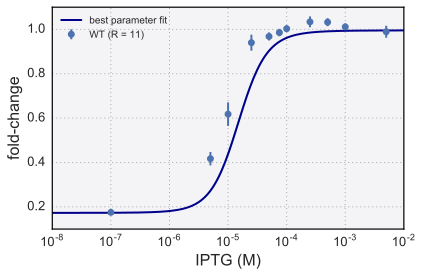

In [70]:
rbs = df[df.rbs=='HG104']
IPTG = np.logspace(-8, -2, 200)
fc_theory = mwc.fold_change_log(IPTG * 1E6, ea, ei, 4.5, R=11, epsilon_r=-13.9)

# compute the mean value for each concentration
fc_mean = rbs.groupby('IPTG_uM').fold_change_A.mean()
# compute the standard error of the mean
fc_err = rbs.groupby('IPTG_uM').fold_change_A.std() / \
np.sqrt(rbs.groupby('IPTG_uM').size())
    
plt.figure()
# Plot theoretical fit
plt.plot(IPTG, fc_theory, '-', label='best parameter fit', color='darkblue')
# plot the experimental data
plt.errorbar(rbs.IPTG_uM.unique() / 1E6, fc_mean, yerr=fc_err, fmt='o',
            label='WT (R = 11)')
# plot 95% HPD region using the variability in the MWC parameters
lower_bound = mwc.fold_change_log(IPTG * 1E6, 
    ea=ea_hpd[0], ei=ei_hpd[0], epsilon=4.5,
    R=rbs.repressors.unique(),
    epsilon_r=-13.9)
upper_bound = mwc.fold_change_log(IPTG * 1E6, 
    ea=ea_hpd[1], ei=ei_hpd[1], epsilon=4.5,
    R=rbs.repressors.unique(),
    epsilon_r=-13.9)
plt.fill_between(IPTG, lower_bound, upper_bound,
                alpha=0.5, color=colors[i])
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

## The role of fluctuations in this stochastic event.

Could it be that since in principle the lacI gene can be thought as an unregulated promoter, the stochastic noise in the repressor copy number per cell is givin this systematic shift? To explore this we will use the chemical master equation approach.

As derived by [Vahid Shahrezaei and Peter S. Swain](http://www.pnas.org/content/105/45/17256.short) in his PNAS paper there is an analytical solution for the two-state promoter protein distribution. In a tangencial project in the lab this distribution with all of its corresponding parameters has been implemented.

We can therefore use this expression to literally draw samples out of the distribution for a variable number of repressors. In other words the algorithm that we will follow to simulate the wild-type data would contain the following steps:
1. Draw out of a Poisson distribution with $\lambda = 11$ the number of repressors that a cell would have.
2. Compute the active number of repressors that this cell would have as a function of the inducer concentration using the best-fit parameters.
3. Knowing the number of active repressors draw out of the corresponding protein distribution a steady-state value of the fluorophore.

We will repeat these steps for all of the IPTG concentrations to see if the natural fluctuations can explain the lack of correspondance between our theory and the data.

Let's begin by reading the pre-computed distribution of protein. This was computed as a matrix in which the column corresponds to the number of repressors, the row corresponds to the number fo proteins and each entry repressents the probability of having that protein copy number.

(0.0, 2100)

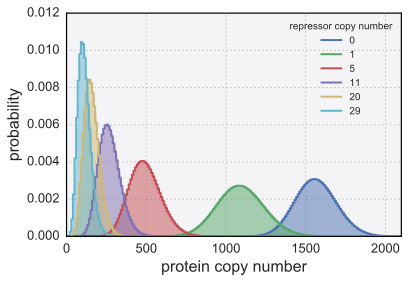

In [71]:
# Read the pre-computed protein distributions
QpR = np.loadtxt('/Users/razo/Documents/PhD/evolution_bits/tmp/QpR_O2_0_30.csv',
                delimiter=',')

# Plot the distribution for some repressors as an example
p_grid = np.arange(0, QpR.shape[0], 10)
r_example = [0, 1, 5, 11, 20, 29]
colors = sns.color_palette(n_colors=len(r_example))
for i, r in enumerate(r_example):
    plt.plot(p_grid, QpR[p_grid, r], drawstyle='steps', label=str(r),
            color=colors[i])
    plt.fill_between(p_grid, QpR[p_grid, r], color=colors[i], alpha=0.5)
plt.xlabel('protein copy number')
plt.ylabel('probability')
plt.legend(loc=0, title='repressor copy number')
plt.xlim(right=2100)

Now that we have the distributions we just need to draw samples out of a Poisson distribution for the repressor copy number, compute the number of active repressors and then draw out of the corresponding distribution.

Let's define a function to do that.

In [105]:
def draw_protein_sample(QpR, n_samples, lam, C, ea, ei, epsilon=4.5):
    '''
    Draws n_samples out of a Poisson distribution with lambda = lam, computes
    the number of active repressors, and then draws out of the corresponding
    protein distribution.
    Parameters
    ----------
    QpR : array-like.
        Matrix where each entry corresponds to the probability of obtaining
        certain protein value. The row number indicates the protein value
        and the column number indicates the number of active repressors.
    n_samples : int.
        Number of samples to be drawn.
    lam : int.
        Mean value of the poisson distribution for the repressor copy number.
    C : float.
        IPTG concentration.
    ea, ei : float.
        Minus log of the dissociation constants of the active and the inactive 
        states respectively.
    epsilon : float.
        energy difference between the active and the inactive state.
    '''
    # Determine the size of the protein array
    p_array = np.arange(QpR.shape[0])
    
    # Draw out of a Poisson distribution
    R_array = np.random.poisson(lam=lam, size=n_samples)
    
    # Compute the active repressor copy number
    # we use the floor function to have a integer repressor copy number
    Ract_array = np.floor(R_array * mwc.pact_log(C, ea, ei, epsilon))
    
    # If one of the samples turns out to be greater than the maximum allowed
    # by the input-output matrix QpR change it to the maximum
    Ract_array[Ract_array >= QpR.shape[1]] = QpR.shape[1] - 1
    
    # Initialize array to save the samples
    p_sample = np.zeros(n_samples)
    # loop through the Ract_array and draw out of the corresponding distribution
    for i, r in enumerate(Ract_array):
        p_sample[i] = np.random.choice(p_array, p=QpR[:,r])
    
    return p_sample

Having defined the function let's draw 40,000 samples for each IPTG concentration to reproduce our flow cytometry data set.

In [73]:
n_samples = 4E4 # Number of samples per concentration
lam = 11 # mean number of repressors
# initialize array to save mean
p_samples_iptg = np.zeros_like(df.IPTG_uM.unique()) 

# loop through IPTG concentrations and draw samles
for i, c in enumerate(df.IPTG_uM.unique()):
    p_samples_iptg[i] = np.mean(draw_protein_sample(QpR, n_samples, \
                                                    lam, c, ea, ei))

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Let's now compute the fold change. In order to get the mean value of the $\Delta lacI$ strain we will use the distribution for 0 repressors and compute

\begin{equation}
\left\langle p \right\rangle_{\Delta lacI} = \sum_{p=0}^\infty p \cdot P(p \mid R=0),
\end{equation}

where $p$ is the protein copy number

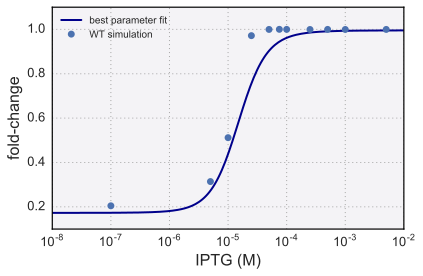

In [74]:
# Compute the mean expression of the delta
mean_delta = np.sum(QpR[:,0] * np.arange(QpR.shape[0]))
# Compute the fold change for our sample
fc = p_samples_iptg / mean_delta

plt.figure()
# Plot theoretical fit
plt.plot(IPTG, fc_theory, '-', label='best parameter fit', color='darkblue')
# plot the experimental data
plt.plot(rbs.IPTG_uM.unique() / 1E6, fc, marker='o',
            label='WT simulation', lw=0)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

Wow... I believe that this indeed could explain the systematic upshift we are finding in the data. Even from the samples some of the fold change values are slightly greater than 1.

## Putting error bars on the simulations.

In order to simulate as similar of an experiment as the ones we have performed for all of the strains let's put error bars on these simulations by repeating it 10 times for each concentration.

In [75]:
n_samples = 4E4 # Number of samples per concentration
n_repeats = 10
lam = 11 # mean number of repressors
# initialize array to save mean
p_samples_iptg = np.zeros([n_repeats, len(df.IPTG_uM.unique())])
# loop through IPTG concentrations and draw samles
for i, c in enumerate(df.IPTG_uM.unique()):
    print('IPTG concentration : {:0.2f} uM'.format(c))
    for r in np.arange(n_repeats):
        p_samples_iptg[r, i] = np.mean(draw_protein_sample(QpR, n_samples, \
                                                        lam, c, ea, ei))

IPTG concentration : 0.00 uM


/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IPTG concentration : 0.10 uM
IPTG concentration : 5.00 uM
IPTG concentration : 10.00 uM
IPTG concentration : 25.00 uM
IPTG concentration : 50.00 uM
IPTG concentration : 75.00 uM
IPTG concentration : 100.00 uM
IPTG concentration : 250.00 uM
IPTG concentration : 500.00 uM
IPTG concentration : 1000.00 uM
IPTG concentration : 5000.00 uM


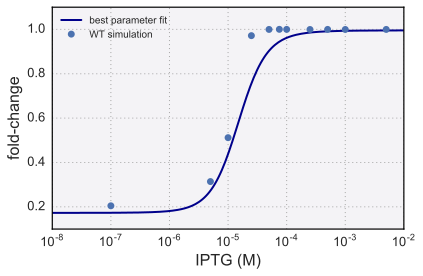

In [77]:
# Compute the mean expression of the delta
mean_delta = np.sum(QpR[:,0] * np.arange(QpR.shape[0]))
# Compute the fold change for our sample
fc_mean = np.mean(p_samples_iptg, axis=0) / mean_delta
fc_err = np.std(p_samples_iptg, axis=0) / mean_delta / np.sqrt(n_repeats)

plt.figure()
# Plot theoretical fit
plt.plot(IPTG, fc_theory, '-', label='best parameter fit', color='darkblue')
# plot the experimental data
plt.errorbar(rbs.IPTG_uM.unique() / 1E6, fc, yerr=fc_err, marker='o',
            label='WT simulation', lw=0)
plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

The error bars are not visible in this plot. That is because as in the cytometer, when your data-set consists of 40,000 samples the structure of the noise behaves almost deterministically

# Drawing an "alternative line" for the wild-type strain with a finer IPTG grid.

Now that we know that at 40,000 sample size the simulations behave almost deterministically, we can draw an alternative line that accounts for this stochasticity by performing the simulations using a finer IPTG grid.

In [106]:
# determine the IPTG concentrations to evaluate
IPTG_grid = np.logspace(-8, -2, 200)
# initialize array to append values
samp_grid = []
def sim_parallel(c):
    sample = np.mean(draw_protein_sample(QpR, n_samples, lam, c * 1E6, ea, ei))
    return sample
samp_grid = Parallel(n_jobs=7)(delayed(sim_parallel)(c) for c in IPTG_grid)

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/razo/anaconda/lib/python3.5/site-packages/ipyker

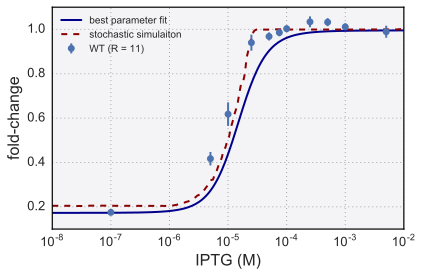

In [108]:
# Compute the mean expression of the delta
mean_delta = np.sum(QpR[:,0] * np.arange(QpR.shape[0]))
# Compute the fold change for our simulation
fc_sim = samp_grid / mean_delta
# compute the mean value for each concentration
fc_mean = rbs.groupby('IPTG_uM').fold_change_A.mean()
# compute the standard error of the mean
fc_err = rbs.groupby('IPTG_uM').fold_change_A.std() / \
np.sqrt(rbs.groupby('IPTG_uM').size())
    

plt.figure()
# Plot theoretical fit
plt.plot(IPTG, fc_theory, '-', label='best parameter fit', color='darkblue')
plt.plot(IPTG_grid, fc_sim, '--', label='stochastic simulaiton',
         color='darkred')
# plot the experimental data
plt.errorbar(rbs.IPTG_uM.unique() / 1E6, fc_mean, yerr=fc_err, fmt='o',
            label='WT (R = 11)')

plt.xscale('log')
plt.xlabel('IPTG (M)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()